In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/ML_AV/KAN

/content/drive/MyDrive/ML_AV/KAN


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn.functional as F
from tqdm import tqdm
import gc



In [ ]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()

        self.conv_1x1_branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv_3x3_branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv_3x3_branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv_3x3_branch4 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.global_avg_pool_branch5 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.ReLU()
        )
        #self.conv_1x1_output = nn.Sequential(
        #    ConvKAN(out_channels * 5, out_channels, kernel_size=1, stride=1),
        #    LayerNorm2D(out_channels)
        #)
        self.conv_1x1_output = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        size = x.shape[2:]

        image_features = self.global_avg_pool_branch5(x)
        image_features = F.interpolate(image_features, size=size, mode='bilinear', align_corners=False)

        conv_1x1 = self.conv_1x1_branch1(x)
        conv_3x3_1 = self.conv_3x3_branch2(x)
        conv_3x3_2 = self.conv_3x3_branch3(x)
        conv_3x3_3 = self.conv_3x3_branch4(x)

        x = torch.cat([image_features, conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3], dim=1)
        x = self.conv_1x1_output(x)

        return x


In [ ]:
resnet101 = models.resnet101(pretrained=True)
resnet101.fc = nn.Identity()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 225MB/s]


In [ ]:
class DeepLabV3Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeepLabV3Encoder, self).__init__()
        self.backbone = resnet101
        self.aspp = ASPP(2048, out_channels)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        low_level_features = self.backbone.layer1(x)
        x = self.backbone.layer2(low_level_features)
        x = self.backbone.layer3(x)
        high_level_features = self.backbone.layer4(x)
        aspp_output = self.aspp(high_level_features)
        return aspp_output, low_level_features

In [ ]:
class DeepLabV3Decoder(nn.Module):
    def __init__(self, low_level_in_channels, low_level_out_channels, num_classes):
        super(DeepLabV3Decoder, self).__init__()
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(low_level_in_channels, low_level_out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(low_level_out_channels),
            nn.ReLU()
        )
        self.concat_conv = nn.Sequential(
            nn.Conv2d(low_level_out_channels + 256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, aspp_output, low_level_features):
        low_level_features = self.low_level_conv(low_level_features)
        aspp_output = F.interpolate(aspp_output, size=low_level_features.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat((aspp_output, low_level_features), dim=1)
        x = self.concat_conv(x)
        x = self.classifier(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        return x

In [ ]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepLabV3Plus, self).__init__()
        self.encoder = DeepLabV3Encoder(in_channels=in_channels, out_channels=256)
        self.decoder = DeepLabV3Decoder(low_level_in_channels=256, low_level_out_channels=48, num_classes=num_classes)

    def forward(self, x):
        aspp_output, low_level_features = self.encoder(x)
        x = self.decoder(aspp_output, low_level_features)
        return x

In [ ]:
from torchsummary import summary
deeplabv3_plus = DeepLabV3Plus(in_channels=3, num_classes=19)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deeplabv3_plus = deeplabv3_plus.to(device)
summary(deeplabv3_plus, (3, 768, 768))
print(deeplabv3_plus)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           9,408
       BatchNorm2d-2         [-1, 64, 384, 384]             128
              ReLU-3         [-1, 64, 384, 384]               0
         MaxPool2d-4         [-1, 64, 192, 192]               0
            Conv2d-5         [-1, 64, 192, 192]           4,096
       BatchNorm2d-6         [-1, 64, 192, 192]             128
              ReLU-7         [-1, 64, 192, 192]               0
            Conv2d-8         [-1, 64, 192, 192]          36,864
       BatchNorm2d-9         [-1, 64, 192, 192]             128
             ReLU-10         [-1, 64, 192, 192]               0
           Conv2d-11        [-1, 256, 192, 192]          16,384
      BatchNorm2d-12        [-1, 256, 192, 192]             512
           Conv2d-13        [-1, 256, 192, 192]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [ ]:
import os
from torchvision.utils import make_grid
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2



class CityscapesDataset(Dataset):
    def __init__(self, root_dir, mode='train', img_size=(768, 768)):
        self.root_dir = root_dir
        self.mode = mode
        self.img_size = img_size

        self.image_paths = []
        self.mask_paths = []

        image_base_dir = os.path.join(root_dir, 'leftImg8bit_trainvaltest/leftImg8bit', mode)
        label_base_dir = os.path.join(root_dir, 'gtFine_trainvaltest/gtFine', mode)

        if not os.path.exists(image_base_dir) or not os.path.exists(label_base_dir):
            raise FileNotFoundError(f"Directories {image_base_dir} or {label_base_dir} do not exist.")

        for city in os.listdir(image_base_dir):
            city_image_dir = os.path.join(image_base_dir, city)
            city_label_dir = os.path.join(label_base_dir, city)

            if os.path.isdir(city_image_dir):
                for image_file in os.listdir(city_image_dir):
                    if image_file.endswith('.png'):
                        self.image_paths.append(os.path.join(city_image_dir, image_file))
                        label_file = image_file.replace('leftImg8bit', 'gtFine_labelIds')
                        self.mask_paths.append(os.path.join(city_label_dir, label_file))

        self.label_map = {
            0: 255,  1: 255,  2: 255,  3: 255,  4: 255,  5: 255,  6: 255,
            7: 0,    8: 1,    9: 255,  10: 255, 11: 2,   12: 3,   13: 4,
            14: 255, 15: 255, 16: 255, 17: 5,   18: 255, 19: 6,   20: 7,
            21: 8,   22: 9,   23: 10,  24: 11,  25: 12,  26: 13,  27: 14,
            28: 15,  29: 255, 30: 255, 31: 16,  32: 17,  33: 18,  -1: 255
        }

        self.train_transforms = A.Compose([
                      A.RandomScale(scale_limit=(0.5, 2), p=0.5),
                      A.RandomCrop(height=768, width=768),
                      A.HorizontalFlip(p=0.5),
                      A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, p=0.5),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                      ToTensorV2()])

        self.eval_transforms = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if image is None or label is None:
            raise RuntimeError(f"Failed to load image or label at index {idx}")

        label = self.map_labels(label)

        # Apply transformations
        if self.mode == 'train':
            transformed = self.train_transforms(image=image, mask=label)
        else:
            transformed = self.eval_transforms(image=image, mask=label)

        image, label = transformed['image'], transformed['mask']

        return image, label

    def map_labels(self, label):
        mapped_label = np.zeros_like(label, dtype=np.uint8)
        for id_, trainId in self.label_map.items():
            mapped_label[label == id_] = trainId
        return mapped_label




/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from torchvision import transforms

# Set the root directory where the Cityscapes dataset is stored
root_dir = '/content/drive/MyDrive/ML_AV/Deeplab/cityscape'

# Create the dataset
train_dataset = CityscapesDataset(
    root_dir=root_dir,
    mode='train',
)

Sample 1:
  Image range: min=-2.1007792949676514, max=2.6399998664855957
  Unique labels in mask: [  0   1   2   3   4   5   7   8  10  11  13 255]
  Labels count: 12


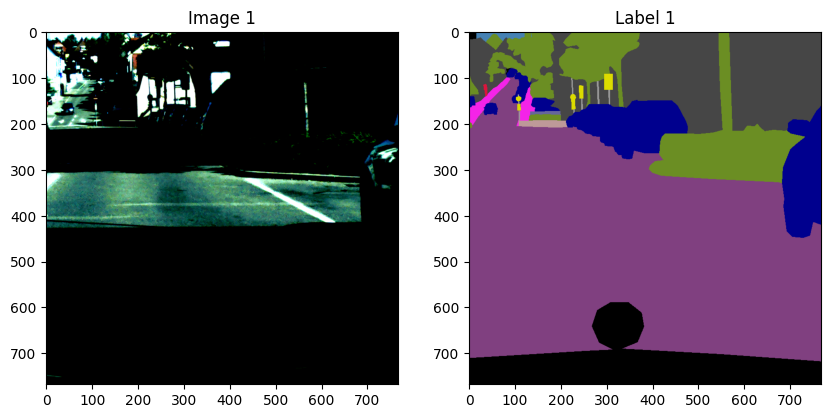

Sample 2:
  Image range: min=-2.1179039478302, max=0.5833551287651062
  Unique labels in mask: [  0   1   2   4   5   6   7   8   9 255]
  Labels count: 10


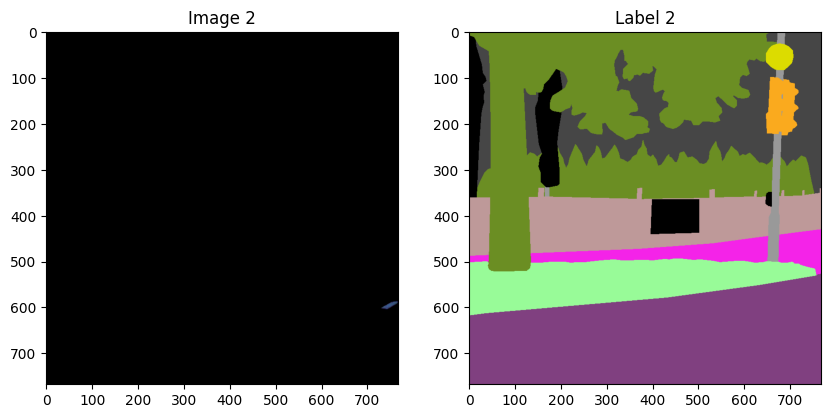

Sample 3:
  Image range: min=-2.1179039478302, max=2.6399998664855957
  Unique labels in mask: [  0   1   2   8   9  10  13  14 255]
  Labels count: 9


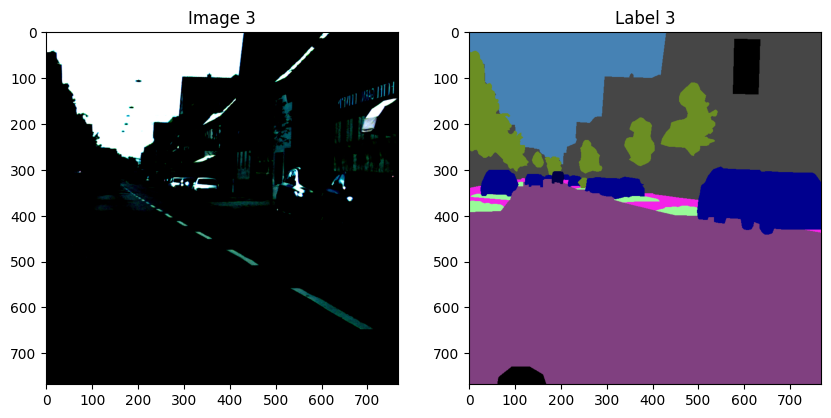

Sample 4:
  Image range: min=-2.0357141494750977, max=2.6399998664855957
  Unique labels in mask: [  0   1   2   5   6   7   8  10  11  13 255]
  Labels count: 11


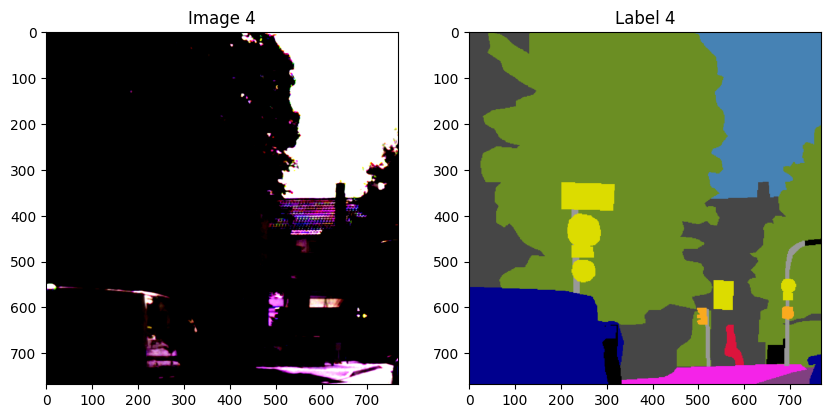

Sample 5:
  Image range: min=-1.3004200458526611, max=1.838257074356079
  Unique labels in mask: [  0   5   6   8  10  13 255]
  Labels count: 7


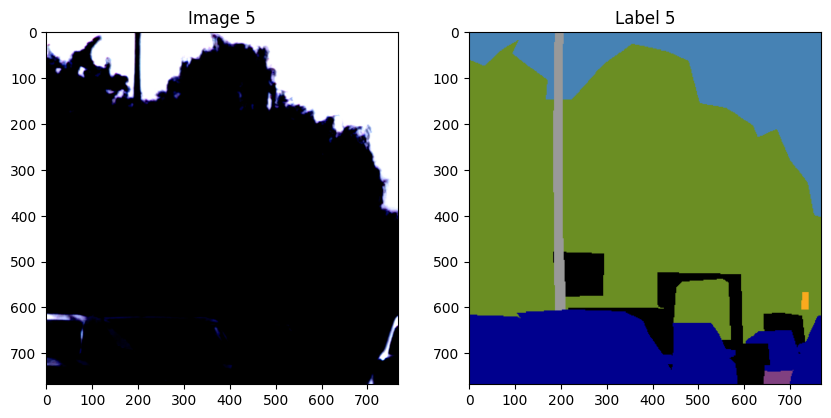

In [ ]:
import colorsys
def give_color_to_seg_img(seg, n_classes):
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)  # Shape (H, W, 3)

    # Predefined color mapping for each class
    class_colors = [
        (0, (128, 64, 128)),   # Road
        (1, (244, 35, 232)),   # Sidewalk
        (2, (70, 70, 70)),    # Building
        (3, (102, 102, 156)), # Wall
        (4, (190, 153, 153)), # Fence
        (5, (153, 153, 153)), # Pole
        (6, (250, 170, 30)),  # Traffic Light
        (7, (220, 220, 0)),   # Traffic Sign
        (8, (107, 142, 35)),  # Vegetation
        (9, (152, 251, 152)), # Terrain
        (10, (70, 130, 180)),  # Sky
        (11, (220, 20, 60)),   # Person
        (12, (255, 0, 0)),     # Rider
        (13, (0, 0, 142)),     # Car
        (14, (0, 0, 70)),      # Truck
        (15, (0, 60, 100)),    # Bus
        (16, (0, 80, 100)),    # Train
        (17, (0, 0, 230)),     # Motorcycle
        (18, (119, 11, 32)),   # Bicycle
        (255, (0,  0,  0))   #Ignore Index
    ]

    # Create a dictionary for quick lookup of colors by class ID
    color_dict = {class_id: color for class_id, color in class_colors}

    for class_id, color in color_dict.items():
        seg_img[seg == class_id] = color  # Assign the corresponding RGB color

    return seg_img

def visualize_samples(dataset, num_samples=4, n_classes=20):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Get the unique labels in the mask
        unique_labels = np.unique(mask.numpy())
        print(f"Sample {i+1}:")
        print(f"  Image range: min={image.min()}, max={image.max()}")
        print(f"  Unique labels in mask: {unique_labels}")
        print(f"  Labels count: {len(unique_labels)}")

        mask_colored = give_color_to_seg_img(mask.numpy(), n_classes)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert back to HWC format
        plt.title(f"Image {i+1}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_colored)
        plt.title(f"Label {i+1}")

        plt.show()

# Example usage
visualize_samples(train_dataset, num_samples=5, n_classes=34)

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filename='best19_aug_focal_loss_base_768*768_resize_model.pth'):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, filename)

def load_checkpoint(model, optimizer, filename='best19_aug_focal_loss_base_768*768_resize_model.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

class PolynomialLRDecay(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, max_iters, power=0.9, last_epoch=-1):
        self.max_iters = max_iters
        self.power = power
        super(PolynomialLRDecay, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * (1 - self.last_epoch / self.max_iters) ** self.power for base_lr in self.base_lrs]


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def calculate_miou(preds, labels, n_classes, ignore_index=255):

    # Filter out ignore_index pixels
    keep = labels != ignore_index
    preds = preds[keep]
    labels = labels[keep]

    # Compute the confusion matrix
    hist = torch.bincount(
        labels * n_classes + preds,
        minlength=n_classes ** 2
    ).view(n_classes, n_classes)

    # Compute IoU
    intersection = torch.diag(hist)
    union = hist.sum(dim=0) + hist.sum(dim=1) - intersection
    ious = intersection / union.clamp(min=1e-6)  # Avoid division by zero
    miou = ious.mean().item()

    return miou, ious

def evaluate(model, val_loader, criterion, device, num_classes, ignore_index=255):

    model.eval()
    val_loss = 0.0
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64, device=device)

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating", leave=False):
            images = images.float().to(device)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Get predictions
            preds = outputs.argmax(dim=1)

            # Update the confusion matrix for mIoU
            keep = masks != ignore_index  # Filter out ignore_index pixels
            preds = preds[keep]
            masks = masks[keep]

            # Flatten and compute mIoU
            if preds.numel() > 0:  # Ensure there are valid pixels
                hist += torch.bincount(
                    masks * num_classes + preds,
                    minlength=num_classes ** 2
                ).view(num_classes, num_classes)

    # Calculate IoU and mIoU
    intersection = torch.diag(hist)
    union = hist.sum(dim=0) + hist.sum(dim=1) - intersection
    ious = intersection / union.clamp(min=1e-6)  # Avoid division by zero
    miou = ious.mean().item()

    val_loss /= len(val_loader.dataset)

    # Print results
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation mIoU: {miou:.4f}")
    print("IoU for each class:")
    for cls in range(num_classes):
        print(f"Class {cls}: IoU = {ious[cls].item():.4f}")

    return val_loss, miou, ious

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_classes, num_epochs, patience, ignore_index=255):

    best_miou = 0.0  # Initialize the best mIoU to 0
    patience_counter = 0  # Initialize patience counter

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False):
            images = images.to(device)
            masks = masks.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        val_loss, miou, ious = evaluate(model, val_loader, criterion, device, num_classes, ignore_index)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val mIoU: {miou:.4f}')

        # Save checkpoint if mIoU improves
        if miou > best_miou:
            best_miou = miou
            save_checkpoint(model, optimizer, epoch + 1, best_miou)
            print(f'Saved best model with mIoU: {best_miou:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping if patience exceeded
        if patience_counter >= patience:
            print(f'Early stopping triggered. No improvement in mIoU for {patience} epochs.')
            break



In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='mean', ignore_index=255):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        # Compute Cross-Entropy Loss without reduction
        ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=self.ignore_index)(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        # Apply the specified reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss  # 'none'

In [ ]:
torch.cuda.empty_cache()
gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(in_channels=3, num_classes=19)
model = model.to(device)





In [ ]:
criterion = FocalLoss(gamma=3, ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4, nesterov=True)

root_dir = '/content/drive/MyDrive/ML_AV/Deeplab/cityscape'
train_set = CityscapesDataset(root_dir, mode='train')
val_set = CityscapesDataset(root_dir, mode='val')

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False, num_workers=2)

scheduler = PolynomialLRDecay(optimizer, max_iters=50 * len(train_loader))

In [ ]:
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_classes=19, num_epochs=50, patience=10)

Validation Loss: 0.0530
Validation mIoU: 0.6652
IoU for each class:
Class 0: IoU = 0.9685
Class 1: IoU = 0.7700
Class 2: IoU = 0.8894
Class 3: IoU = 0.5100
Class 4: IoU = 0.5035
Class 5: IoU = 0.4793
Class 6: IoU = 0.5320
Class 7: IoU = 0.6279
Class 8: IoU = 0.8943
Class 9: IoU = 0.5651
Class 10: IoU = 0.9179
Class 11: IoU = 0.7067
Class 12: IoU = 0.4954
Class 13: IoU = 0.9163
Class 14: IoU = 0.6111
Class 15: IoU = 0.6471
Class 16: IoU = 0.4209
Class 17: IoU = 0.5189
Class 18: IoU = 0.6656
Epoch 1/50, Train Loss: 0.0640, Val Loss: 0.0530, Val mIoU: 0.6652
Saved best model with mIoU: 0.6652


Validation Loss: 0.0530
Validation mIoU: 0.6656
IoU for each class:
Class 0: IoU = 0.9702
Class 1: IoU = 0.7790
Class 2: IoU = 0.8890
Class 3: IoU = 0.5090
Class 4: IoU = 0.5070
Class 5: IoU = 0.4697
Class 6: IoU = 0.5342
Class 7: IoU = 0.6239
Class 8: IoU = 0.8956
Class 9: IoU = 0.5672
Class 10: IoU = 0.9169
Class 11: IoU = 0.7053
Class 12: IoU = 0.4996
Class 13: IoU = 0.9157
Class 14: IoU = 0.5337
Class 15: IoU = 0.6941
Class 16: IoU = 0.4344
Class 17: IoU = 0.5306
Class 18: IoU = 0.6718
Epoch 2/50, Train Loss: 0.0656, Val Loss: 0.0530, Val mIoU: 0.6656
Saved best model with mIoU: 0.6656


Validation Loss: 0.0541
Validation mIoU: 0.6662
IoU for each class:
Class 0: IoU = 0.9700
Class 1: IoU = 0.7766
Class 2: IoU = 0.8873
Class 3: IoU = 0.5108
Class 4: IoU = 0.4879
Class 5: IoU = 0.4654
Class 6: IoU = 0.5293
Class 7: IoU = 0.6251
Class 8: IoU = 0.8961
Class 9: IoU = 0.5578
Class 10: IoU = 0.9178
Class 11: IoU = 0.7015
Class 12: IoU = 0.4895
Class 13: IoU = 0.9163
Class 14: IoU = 0.5869
Class 15: IoU = 0.6795
Class 16: IoU = 0.4802
Class 17: IoU = 0.5085
Class 18: IoU = 0.6703
Epoch 3/50, Train Loss: 0.0666, Val Loss: 0.0541, Val mIoU: 0.6662
Saved best model with mIoU: 0.6662


Validation Loss: 0.0553
Validation mIoU: 0.6666
IoU for each class:
Class 0: IoU = 0.9680
Class 1: IoU = 0.7725
Class 2: IoU = 0.8885
Class 3: IoU = 0.5111
Class 4: IoU = 0.4881
Class 5: IoU = 0.4749
Class 6: IoU = 0.5371
Class 7: IoU = 0.6287
Class 8: IoU = 0.8942
Class 9: IoU = 0.5421
Class 10: IoU = 0.9158
Class 11: IoU = 0.7031
Class 12: IoU = 0.5032
Class 13: IoU = 0.9089
Class 14: IoU = 0.5428
Class 15: IoU = 0.6774
Class 16: IoU = 0.5093
Class 17: IoU = 0.5318
Class 18: IoU = 0.6675
Epoch 4/50, Train Loss: 0.0642, Val Loss: 0.0553, Val mIoU: 0.6666
Saved best model with mIoU: 0.6666


Validation Loss: 0.0537
Validation mIoU: 0.6716
IoU for each class:
Class 0: IoU = 0.9702
Class 1: IoU = 0.7754
Class 2: IoU = 0.8897
Class 3: IoU = 0.4961
Class 4: IoU = 0.5089
Class 5: IoU = 0.4891
Class 6: IoU = 0.5355
Class 7: IoU = 0.6197
Class 8: IoU = 0.8941
Class 9: IoU = 0.5423
Class 10: IoU = 0.9159
Class 11: IoU = 0.7100
Class 12: IoU = 0.4898
Class 13: IoU = 0.9144
Class 14: IoU = 0.6488
Class 15: IoU = 0.6807
Class 16: IoU = 0.4708
Class 17: IoU = 0.5323
Class 18: IoU = 0.6765
Epoch 5/50, Train Loss: 0.0666, Val Loss: 0.0537, Val mIoU: 0.6716
Saved best model with mIoU: 0.6716


Validation Loss: 0.0537
Validation mIoU: 0.6653
IoU for each class:
Class 0: IoU = 0.9697
Class 1: IoU = 0.7805
Class 2: IoU = 0.8894
Class 3: IoU = 0.4960
Class 4: IoU = 0.5020
Class 5: IoU = 0.4861
Class 6: IoU = 0.5295
Class 7: IoU = 0.6031
Class 8: IoU = 0.8943
Class 9: IoU = 0.5462
Class 10: IoU = 0.9144
Class 11: IoU = 0.7056
Class 12: IoU = 0.5016
Class 13: IoU = 0.9109
Class 14: IoU = 0.5632
Class 15: IoU = 0.6637
Class 16: IoU = 0.5004
Class 17: IoU = 0.5154
Class 18: IoU = 0.6679
Epoch 6/50, Train Loss: 0.0688, Val Loss: 0.0537, Val mIoU: 0.6653


Validation Loss: 0.0545
Validation mIoU: 0.6569
IoU for each class:
Class 0: IoU = 0.9687
Class 1: IoU = 0.7783
Class 2: IoU = 0.8863
Class 3: IoU = 0.4829
Class 4: IoU = 0.4909
Class 5: IoU = 0.4902
Class 6: IoU = 0.5343
Class 7: IoU = 0.6074
Class 8: IoU = 0.8936
Class 9: IoU = 0.5308
Class 10: IoU = 0.9113
Class 11: IoU = 0.6947
Class 12: IoU = 0.4843
Class 13: IoU = 0.9168
Class 14: IoU = 0.6019
Class 15: IoU = 0.6014
Class 16: IoU = 0.4089
Class 17: IoU = 0.5228
Class 18: IoU = 0.6752
Epoch 7/50, Train Loss: 0.0667, Val Loss: 0.0545, Val mIoU: 0.6569


Validation Loss: 0.0526
Validation mIoU: 0.6691
IoU for each class:
Class 0: IoU = 0.9699
Class 1: IoU = 0.7781
Class 2: IoU = 0.8874
Class 3: IoU = 0.4897
Class 4: IoU = 0.5048
Class 5: IoU = 0.4912
Class 6: IoU = 0.5435
Class 7: IoU = 0.6304
Class 8: IoU = 0.8954
Class 9: IoU = 0.5319
Class 10: IoU = 0.9128
Class 11: IoU = 0.7047
Class 12: IoU = 0.4953
Class 13: IoU = 0.9156
Class 14: IoU = 0.6227
Class 15: IoU = 0.7014
Class 16: IoU = 0.4354
Class 17: IoU = 0.5286
Class 18: IoU = 0.6749
Epoch 8/50, Train Loss: 0.0656, Val Loss: 0.0526, Val mIoU: 0.6691


Validation Loss: 0.0535
Validation mIoU: 0.6737
IoU for each class:
Class 0: IoU = 0.9682
Class 1: IoU = 0.7728
Class 2: IoU = 0.8864
Class 3: IoU = 0.5121
Class 4: IoU = 0.4967
Class 5: IoU = 0.4872
Class 6: IoU = 0.5357
Class 7: IoU = 0.6120
Class 8: IoU = 0.8932
Class 9: IoU = 0.5666
Class 10: IoU = 0.9137
Class 11: IoU = 0.6875
Class 12: IoU = 0.4470
Class 13: IoU = 0.9160
Class 14: IoU = 0.6467
Class 15: IoU = 0.7237
Class 16: IoU = 0.5542
Class 17: IoU = 0.5084
Class 18: IoU = 0.6729
Epoch 9/50, Train Loss: 0.0724, Val Loss: 0.0535, Val mIoU: 0.6737
Saved best model with mIoU: 0.6737


Validation Loss: 0.0546
Validation mIoU: 0.6635
IoU for each class:
Class 0: IoU = 0.9686
Class 1: IoU = 0.7757
Class 2: IoU = 0.8902
Class 3: IoU = 0.4798
Class 4: IoU = 0.4769
Class 5: IoU = 0.4855
Class 6: IoU = 0.5293
Class 7: IoU = 0.6318
Class 8: IoU = 0.8944
Class 9: IoU = 0.5413
Class 10: IoU = 0.9122
Class 11: IoU = 0.7072
Class 12: IoU = 0.4870
Class 13: IoU = 0.9139
Class 14: IoU = 0.5881
Class 15: IoU = 0.6676
Class 16: IoU = 0.4546
Class 17: IoU = 0.5256
Class 18: IoU = 0.6774
Epoch 10/50, Train Loss: 0.0679, Val Loss: 0.0546, Val mIoU: 0.6635


Validation Loss: 0.0525
Validation mIoU: 0.6757
IoU for each class:
Class 0: IoU = 0.9700
Class 1: IoU = 0.7736
Class 2: IoU = 0.8892
Class 3: IoU = 0.4986
Class 4: IoU = 0.4873
Class 5: IoU = 0.4795
Class 6: IoU = 0.5389
Class 7: IoU = 0.6344
Class 8: IoU = 0.8922
Class 9: IoU = 0.5336
Class 10: IoU = 0.9141
Class 11: IoU = 0.7067
Class 12: IoU = 0.5005
Class 13: IoU = 0.9173
Class 14: IoU = 0.6499
Class 15: IoU = 0.7208
Class 16: IoU = 0.5435
Class 17: IoU = 0.5179
Class 18: IoU = 0.6713
Epoch 11/50, Train Loss: 0.0660, Val Loss: 0.0525, Val mIoU: 0.6757
Saved best model with mIoU: 0.6757


Validation Loss: 0.0529
Validation mIoU: 0.6684
IoU for each class:
Class 0: IoU = 0.9698
Class 1: IoU = 0.7749
Class 2: IoU = 0.8888
Class 3: IoU = 0.5063
Class 4: IoU = 0.4838
Class 5: IoU = 0.4559
Class 6: IoU = 0.5434
Class 7: IoU = 0.6134
Class 8: IoU = 0.8951
Class 9: IoU = 0.5392
Class 10: IoU = 0.9159
Class 11: IoU = 0.7021
Class 12: IoU = 0.4843
Class 13: IoU = 0.9170
Class 14: IoU = 0.6197
Class 15: IoU = 0.7180
Class 16: IoU = 0.5066
Class 17: IoU = 0.5023
Class 18: IoU = 0.6630
Epoch 12/50, Train Loss: 0.0633, Val Loss: 0.0529, Val mIoU: 0.6684


Validation Loss: 0.0522
Validation mIoU: 0.6780
IoU for each class:
Class 0: IoU = 0.9697
Class 1: IoU = 0.7745
Class 2: IoU = 0.8897
Class 3: IoU = 0.5170
Class 4: IoU = 0.4977
Class 5: IoU = 0.4794
Class 6: IoU = 0.5215
Class 7: IoU = 0.6343
Class 8: IoU = 0.8923
Class 9: IoU = 0.5812
Class 10: IoU = 0.9164
Class 11: IoU = 0.7065
Class 12: IoU = 0.4708
Class 13: IoU = 0.9190
Class 14: IoU = 0.6391
Class 15: IoU = 0.7414
Class 16: IoU = 0.5767
Class 17: IoU = 0.4866
Class 18: IoU = 0.6673
Epoch 13/50, Train Loss: 0.0667, Val Loss: 0.0522, Val mIoU: 0.6780
Saved best model with mIoU: 0.6780


Validation Loss: 0.0549
Validation mIoU: 0.6667
IoU for each class:
Class 0: IoU = 0.9669
Class 1: IoU = 0.7568
Class 2: IoU = 0.8874
Class 3: IoU = 0.4962
Class 4: IoU = 0.4922
Class 5: IoU = 0.4866
Class 6: IoU = 0.5346
Class 7: IoU = 0.6313
Class 8: IoU = 0.8924
Class 9: IoU = 0.4530
Class 10: IoU = 0.9168
Class 11: IoU = 0.6985
Class 12: IoU = 0.4862
Class 13: IoU = 0.9158
Class 14: IoU = 0.6368
Class 15: IoU = 0.7309
Class 16: IoU = 0.5216
Class 17: IoU = 0.4908
Class 18: IoU = 0.6722
Epoch 14/50, Train Loss: 0.0636, Val Loss: 0.0549, Val mIoU: 0.6667


Validation Loss: 0.0515
Validation mIoU: 0.6806
IoU for each class:
Class 0: IoU = 0.9713
Class 1: IoU = 0.7874
Class 2: IoU = 0.8905
Class 3: IoU = 0.5246
Class 4: IoU = 0.4974
Class 5: IoU = 0.4922
Class 6: IoU = 0.5405
Class 7: IoU = 0.6447
Class 8: IoU = 0.8974
Class 9: IoU = 0.5691
Class 10: IoU = 0.9158
Class 11: IoU = 0.7093
Class 12: IoU = 0.4923
Class 13: IoU = 0.9149
Class 14: IoU = 0.6090
Class 15: IoU = 0.7082
Class 16: IoU = 0.5583
Class 17: IoU = 0.5274
Class 18: IoU = 0.6813
Epoch 15/50, Train Loss: 0.0652, Val Loss: 0.0515, Val mIoU: 0.6806
Saved best model with mIoU: 0.6806


Validation Loss: 0.0516
Validation mIoU: 0.6703
IoU for each class:
Class 0: IoU = 0.9696
Class 1: IoU = 0.7738
Class 2: IoU = 0.8892
Class 3: IoU = 0.5175
Class 4: IoU = 0.5188
Class 5: IoU = 0.4796
Class 6: IoU = 0.5401
Class 7: IoU = 0.6323
Class 8: IoU = 0.8958
Class 9: IoU = 0.5509
Class 10: IoU = 0.9160
Class 11: IoU = 0.7044
Class 12: IoU = 0.4810
Class 13: IoU = 0.9131
Class 14: IoU = 0.5700
Class 15: IoU = 0.7016
Class 16: IoU = 0.4764
Class 17: IoU = 0.5327
Class 18: IoU = 0.6734
Epoch 16/50, Train Loss: 0.0644, Val Loss: 0.0516, Val mIoU: 0.6703


Validation Loss: 0.0520
Validation mIoU: 0.6769
IoU for each class:
Class 0: IoU = 0.9710
Class 1: IoU = 0.7833
Class 2: IoU = 0.8914
Class 3: IoU = 0.5154
Class 4: IoU = 0.5197
Class 5: IoU = 0.4922
Class 6: IoU = 0.5339
Class 7: IoU = 0.6220
Class 8: IoU = 0.8956
Class 9: IoU = 0.5676
Class 10: IoU = 0.9109
Class 11: IoU = 0.7044
Class 12: IoU = 0.4968
Class 13: IoU = 0.9210
Class 14: IoU = 0.6569
Class 15: IoU = 0.7037
Class 16: IoU = 0.5105
Class 17: IoU = 0.4947
Class 18: IoU = 0.6690
Epoch 17/50, Train Loss: 0.0641, Val Loss: 0.0520, Val mIoU: 0.6769


Validation Loss: 0.0529
Validation mIoU: 0.6725
IoU for each class:
Class 0: IoU = 0.9703
Class 1: IoU = 0.7761
Class 2: IoU = 0.8907
Class 3: IoU = 0.5032
Class 4: IoU = 0.4648
Class 5: IoU = 0.4896
Class 6: IoU = 0.5397
Class 7: IoU = 0.6397
Class 8: IoU = 0.8960
Class 9: IoU = 0.5650
Class 10: IoU = 0.9180
Class 11: IoU = 0.7139
Class 12: IoU = 0.5018
Class 13: IoU = 0.9151
Class 14: IoU = 0.5670
Class 15: IoU = 0.7240
Class 16: IoU = 0.4966
Class 17: IoU = 0.5295
Class 18: IoU = 0.6756
Epoch 18/50, Train Loss: 0.0681, Val Loss: 0.0529, Val mIoU: 0.6725


Validation Loss: 0.0513
Validation mIoU: 0.6750
IoU for each class:
Class 0: IoU = 0.9710
Class 1: IoU = 0.7923
Class 2: IoU = 0.8924
Class 3: IoU = 0.5216
Class 4: IoU = 0.5088
Class 5: IoU = 0.4840
Class 6: IoU = 0.5378
Class 7: IoU = 0.6259
Class 8: IoU = 0.8974
Class 9: IoU = 0.5682
Class 10: IoU = 0.9197
Class 11: IoU = 0.7088
Class 12: IoU = 0.4773
Class 13: IoU = 0.9145
Class 14: IoU = 0.5648
Class 15: IoU = 0.7030
Class 16: IoU = 0.5359
Class 17: IoU = 0.5196
Class 18: IoU = 0.6823
Epoch 19/50, Train Loss: 0.0616, Val Loss: 0.0513, Val mIoU: 0.6750


Validation Loss: 0.0523
Validation mIoU: 0.6790
IoU for each class:
Class 0: IoU = 0.9707
Class 1: IoU = 0.7781
Class 2: IoU = 0.8873
Class 3: IoU = 0.4814
Class 4: IoU = 0.5096
Class 5: IoU = 0.4809
Class 6: IoU = 0.5400
Class 7: IoU = 0.6369
Class 8: IoU = 0.8912
Class 9: IoU = 0.6081
Class 10: IoU = 0.9149
Class 11: IoU = 0.7112
Class 12: IoU = 0.4922
Class 13: IoU = 0.9172
Class 14: IoU = 0.6139
Class 15: IoU = 0.7142
Class 16: IoU = 0.5731
Class 17: IoU = 0.5104
Class 18: IoU = 0.6701
Epoch 20/50, Train Loss: 0.0672, Val Loss: 0.0523, Val mIoU: 0.6790


Validation Loss: 0.0508
Validation mIoU: 0.6798
IoU for each class:
Class 0: IoU = 0.9704
Class 1: IoU = 0.7802
Class 2: IoU = 0.8916
Class 3: IoU = 0.5179
Class 4: IoU = 0.5241
Class 5: IoU = 0.4833
Class 6: IoU = 0.5399
Class 7: IoU = 0.6475
Class 8: IoU = 0.8983
Class 9: IoU = 0.5697
Class 10: IoU = 0.9132
Class 11: IoU = 0.7148
Class 12: IoU = 0.5024
Class 13: IoU = 0.9183
Class 14: IoU = 0.6324
Class 15: IoU = 0.6911
Class 16: IoU = 0.5212
Class 17: IoU = 0.5210
Class 18: IoU = 0.6795
Epoch 21/50, Train Loss: 0.0636, Val Loss: 0.0508, Val mIoU: 0.6798


Validation Loss: 0.0515
Validation mIoU: 0.6765
IoU for each class:
Class 0: IoU = 0.9701
Class 1: IoU = 0.7871
Class 2: IoU = 0.8931
Class 3: IoU = 0.5053
Class 4: IoU = 0.5129
Class 5: IoU = 0.4966
Class 6: IoU = 0.5432
Class 7: IoU = 0.6374
Class 8: IoU = 0.8993
Class 9: IoU = 0.5615
Class 10: IoU = 0.9189
Class 11: IoU = 0.7097
Class 12: IoU = 0.4896
Class 13: IoU = 0.9180
Class 14: IoU = 0.5619
Class 15: IoU = 0.7010
Class 16: IoU = 0.5294
Class 17: IoU = 0.5348
Class 18: IoU = 0.6843
Epoch 22/50, Train Loss: 0.0613, Val Loss: 0.0515, Val mIoU: 0.6765


Validation Loss: 0.0515
Validation mIoU: 0.6867
IoU for each class:
Class 0: IoU = 0.9697
Class 1: IoU = 0.7867
Class 2: IoU = 0.8913
Class 3: IoU = 0.5073
Class 4: IoU = 0.5158
Class 5: IoU = 0.4940
Class 6: IoU = 0.5473
Class 7: IoU = 0.6301
Class 8: IoU = 0.8982
Class 9: IoU = 0.5631
Class 10: IoU = 0.9107
Class 11: IoU = 0.7101
Class 12: IoU = 0.4966
Class 13: IoU = 0.9188
Class 14: IoU = 0.6401
Class 15: IoU = 0.7434
Class 16: IoU = 0.5871
Class 17: IoU = 0.5539
Class 18: IoU = 0.6822
Epoch 23/50, Train Loss: 0.0646, Val Loss: 0.0515, Val mIoU: 0.6867
Saved best model with mIoU: 0.6867


Validation Loss: 0.0520
Validation mIoU: 0.6757
IoU for each class:
Class 0: IoU = 0.9705
Class 1: IoU = 0.7959
Class 2: IoU = 0.8922
Class 3: IoU = 0.5174
Class 4: IoU = 0.5055
Class 5: IoU = 0.5002
Class 6: IoU = 0.5431
Class 7: IoU = 0.6506
Class 8: IoU = 0.8988
Class 9: IoU = 0.5536
Class 10: IoU = 0.9162
Class 11: IoU = 0.7155
Class 12: IoU = 0.4981
Class 13: IoU = 0.9177
Class 14: IoU = 0.6394
Class 15: IoU = 0.6961
Class 16: IoU = 0.4037
Class 17: IoU = 0.5416
Class 18: IoU = 0.6821
Epoch 24/50, Train Loss: 0.0617, Val Loss: 0.0520, Val mIoU: 0.6757


Validation Loss: 0.0512
Validation mIoU: 0.6794
IoU for each class:
Class 0: IoU = 0.9723
Class 1: IoU = 0.7949
Class 2: IoU = 0.8914
Class 3: IoU = 0.5026
Class 4: IoU = 0.5206
Class 5: IoU = 0.4759
Class 6: IoU = 0.5361
Class 7: IoU = 0.6152
Class 8: IoU = 0.8979
Class 9: IoU = 0.5863
Class 10: IoU = 0.9153
Class 11: IoU = 0.7149
Class 12: IoU = 0.5072
Class 13: IoU = 0.9179
Class 14: IoU = 0.5907
Class 15: IoU = 0.7526
Class 16: IoU = 0.5236
Class 17: IoU = 0.5120
Class 18: IoU = 0.6819
Epoch 25/50, Train Loss: 0.0641, Val Loss: 0.0512, Val mIoU: 0.6794


Validation Loss: 0.0507
Validation mIoU: 0.6826
IoU for each class:
Class 0: IoU = 0.9725
Class 1: IoU = 0.7941
Class 2: IoU = 0.8933
Class 3: IoU = 0.4954
Class 4: IoU = 0.5053
Class 5: IoU = 0.4887
Class 6: IoU = 0.5381
Class 7: IoU = 0.6468
Class 8: IoU = 0.8976
Class 9: IoU = 0.5775
Class 10: IoU = 0.9171
Class 11: IoU = 0.7082
Class 12: IoU = 0.4223
Class 13: IoU = 0.9213
Class 14: IoU = 0.6265
Class 15: IoU = 0.7529
Class 16: IoU = 0.6104
Class 17: IoU = 0.5160
Class 18: IoU = 0.6848
Epoch 26/50, Train Loss: 0.0605, Val Loss: 0.0507, Val mIoU: 0.6826


Validation Loss: 0.0513
Validation mIoU: 0.6787
IoU for each class:
Class 0: IoU = 0.9720
Class 1: IoU = 0.7809
Class 2: IoU = 0.8920
Class 3: IoU = 0.4888
Class 4: IoU = 0.5181
Class 5: IoU = 0.4901
Class 6: IoU = 0.5365
Class 7: IoU = 0.6504
Class 8: IoU = 0.8968
Class 9: IoU = 0.5724
Class 10: IoU = 0.9174
Class 11: IoU = 0.7207
Class 12: IoU = 0.4990
Class 13: IoU = 0.9192
Class 14: IoU = 0.5964
Class 15: IoU = 0.7298
Class 16: IoU = 0.5186
Class 17: IoU = 0.5127
Class 18: IoU = 0.6834
Epoch 27/50, Train Loss: 0.0599, Val Loss: 0.0513, Val mIoU: 0.6787


Validation Loss: 0.0510
Validation mIoU: 0.6790
IoU for each class:
Class 0: IoU = 0.9723
Class 1: IoU = 0.7930
Class 2: IoU = 0.8895
Class 3: IoU = 0.4808
Class 4: IoU = 0.4999
Class 5: IoU = 0.4781
Class 6: IoU = 0.5240
Class 7: IoU = 0.6171
Class 8: IoU = 0.8974
Class 9: IoU = 0.5799
Class 10: IoU = 0.9012
Class 11: IoU = 0.7151
Class 12: IoU = 0.5138
Class 13: IoU = 0.9189
Class 14: IoU = 0.6096
Class 15: IoU = 0.7074
Class 16: IoU = 0.5891
Class 17: IoU = 0.5340
Class 18: IoU = 0.6798
Epoch 28/50, Train Loss: 0.0608, Val Loss: 0.0510, Val mIoU: 0.6790


Validation Loss: 0.0499
Validation mIoU: 0.6843
IoU for each class:
Class 0: IoU = 0.9724
Class 1: IoU = 0.7934
Class 2: IoU = 0.8907
Class 3: IoU = 0.4946
Class 4: IoU = 0.5230
Class 5: IoU = 0.4906
Class 6: IoU = 0.5512
Class 7: IoU = 0.6466
Class 8: IoU = 0.8979
Class 9: IoU = 0.5597
Class 10: IoU = 0.9063
Class 11: IoU = 0.7174
Class 12: IoU = 0.5002
Class 13: IoU = 0.9193
Class 14: IoU = 0.5969
Class 15: IoU = 0.7527
Class 16: IoU = 0.5839
Class 17: IoU = 0.5256
Class 18: IoU = 0.6794
Epoch 29/50, Train Loss: 0.0633, Val Loss: 0.0499, Val mIoU: 0.6843


Validation Loss: 0.0511
Validation mIoU: 0.6674
IoU for each class:
Class 0: IoU = 0.9720
Class 1: IoU = 0.7892
Class 2: IoU = 0.8911
Class 3: IoU = 0.5138
Class 4: IoU = 0.5016
Class 5: IoU = 0.4853
Class 6: IoU = 0.5325
Class 7: IoU = 0.6296
Class 8: IoU = 0.8987
Class 9: IoU = 0.5816
Class 10: IoU = 0.9170
Class 11: IoU = 0.7118
Class 12: IoU = 0.4807
Class 13: IoU = 0.9210
Class 14: IoU = 0.5747
Class 15: IoU = 0.6733
Class 16: IoU = 0.3793
Class 17: IoU = 0.5437
Class 18: IoU = 0.6837
Epoch 30/50, Train Loss: 0.0598, Val Loss: 0.0511, Val mIoU: 0.6674


Validation Loss: 0.0500
Validation mIoU: 0.6840
IoU for each class:
Class 0: IoU = 0.9718
Class 1: IoU = 0.7925
Class 2: IoU = 0.8924
Class 3: IoU = 0.4952
Class 4: IoU = 0.5063
Class 5: IoU = 0.5037
Class 6: IoU = 0.5521
Class 7: IoU = 0.6555
Class 8: IoU = 0.8974
Class 9: IoU = 0.5769
Class 10: IoU = 0.9199
Class 11: IoU = 0.7135
Class 12: IoU = 0.5153
Class 13: IoU = 0.9196
Class 14: IoU = 0.6126
Class 15: IoU = 0.7378
Class 16: IoU = 0.5182
Class 17: IoU = 0.5360
Class 18: IoU = 0.6800
Epoch 31/50, Train Loss: 0.0593, Val Loss: 0.0500, Val mIoU: 0.6840


Validation Loss: 0.0503
Validation mIoU: 0.6774
IoU for each class:
Class 0: IoU = 0.9714
Class 1: IoU = 0.7859
Class 2: IoU = 0.8939
Class 3: IoU = 0.5104
Class 4: IoU = 0.5174
Class 5: IoU = 0.5013
Class 6: IoU = 0.5553
Class 7: IoU = 0.6402
Class 8: IoU = 0.8982
Class 9: IoU = 0.5472
Class 10: IoU = 0.9207
Class 11: IoU = 0.7176
Class 12: IoU = 0.5126
Class 13: IoU = 0.9173
Class 14: IoU = 0.5360
Class 15: IoU = 0.7081
Class 16: IoU = 0.5108
Class 17: IoU = 0.5462
Class 18: IoU = 0.6793
Epoch 32/50, Train Loss: 0.0609, Val Loss: 0.0503, Val mIoU: 0.6774


Validation Loss: 0.0515
Validation mIoU: 0.6754
IoU for each class:
Class 0: IoU = 0.9694
Class 1: IoU = 0.7814
Class 2: IoU = 0.8930
Class 3: IoU = 0.5019
Class 4: IoU = 0.4989
Class 5: IoU = 0.4932
Class 6: IoU = 0.5386
Class 7: IoU = 0.6517
Class 8: IoU = 0.8993
Class 9: IoU = 0.5565
Class 10: IoU = 0.9188
Class 11: IoU = 0.7133
Class 12: IoU = 0.5035
Class 13: IoU = 0.9146
Class 14: IoU = 0.5497
Class 15: IoU = 0.7265
Class 16: IoU = 0.5003
Class 17: IoU = 0.5383
Class 18: IoU = 0.6833
Epoch 33/50, Train Loss: 0.0632, Val Loss: 0.0515, Val mIoU: 0.6754
Early stopping triggered. No improvement in mIoU for 10 epochs.


In [ ]:
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
def denormalize(image, mean, std):
    # Convert the image to float if it's not
    image = image.astype(np.float32)

    # Ensure mean and std are numpy arrays
    mean = np.array(mean)
    std = np.array(std)

    # Denormalize each channel (R, G, B)
    for i in range(3):
        image[..., i] = image[..., i] * std[i] + mean[i]

    return np.clip(image, 0, 1)  # Ensure pixel values are within [0, 1]

# Updated demo_inference function
def demo_inference(
    model, dataset, n_classes=34, num_samples=10,
    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),
    ignore_label=255):

    model.eval()
    start = random.randint(0, len(dataset) - num_samples)

    for i in range(start, start + num_samples):
        # Load and preprocess the sample
        image, mask = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()  # Convert to HWC
        image_np = denormalize(image_np, mean=mean, std=std)  # Denormalize image
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        input_image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        with torch.no_grad():
            output = model(input_image)
            predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Handle "uncare" regions in ground truth and prediction
        valid_mask = mask.numpy() != ignore_label
        ground_truth_img = give_color_to_seg_img(mask.numpy(), n_classes)
        predicted_mask_img = give_color_to_seg_img(predicted_mask, n_classes)

        # Overlay valid regions only
        overlay = image_np.copy()
        overlay[valid_mask] = (
            0.6 * image_np[valid_mask] + 0.4 * (predicted_mask_img[valid_mask] / 255.0)
        )
        overlay = np.clip(overlay, 0, 1)  # Ensure values are within [0, 1]

        # Plot the visualizations
        fig, axes = plt.subplots(1, 4, figsize=(25, 10))

        axes[0].imshow(image_np)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(ground_truth_img)
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis("off")

        axes[2].imshow(predicted_mask_img)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        axes[3].imshow(overlay)
        axes[3].set_title("Overlay (Prediction + Original)")
        axes[3].axis("off")

        plt.show()





In [ ]:
# Load the model and checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('best19_aug_focal_loss_base_768*768_resize_model.pth', map_location=device)

# Assuming your model is already defined
model = DeepLabV3Plus(num_classes=19,in_channels=3).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

val_loss, val_accuracy, overall_miou = evaluate(model, val_loader, criterion, device, num_classes=19)

<ipython-input-26-1d5d2868cd2d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best19_aug_focal_loss_base_768*768_resize_model.pth', map_location=

Validation Loss: 0.0515
Validation mIoU: 0.6867
IoU for each class:
Class 0: IoU = 0.9697
Class 1: IoU = 0.7867
Class 2: IoU = 0.8913
Class 3: IoU = 0.5073
Class 4: IoU = 0.5158
Class 5: IoU = 0.4940
Class 6: IoU = 0.5473
Class 7: IoU = 0.6301
Class 8: IoU = 0.8982
Class 9: IoU = 0.5631
Class 10: IoU = 0.9107
Class 11: IoU = 0.7101
Class 12: IoU = 0.4966
Class 13: IoU = 0.9188
Class 14: IoU = 0.6401
Class 15: IoU = 0.7434
Class 16: IoU = 0.5871
Class 17: IoU = 0.5539
Class 18: IoU = 0.6822


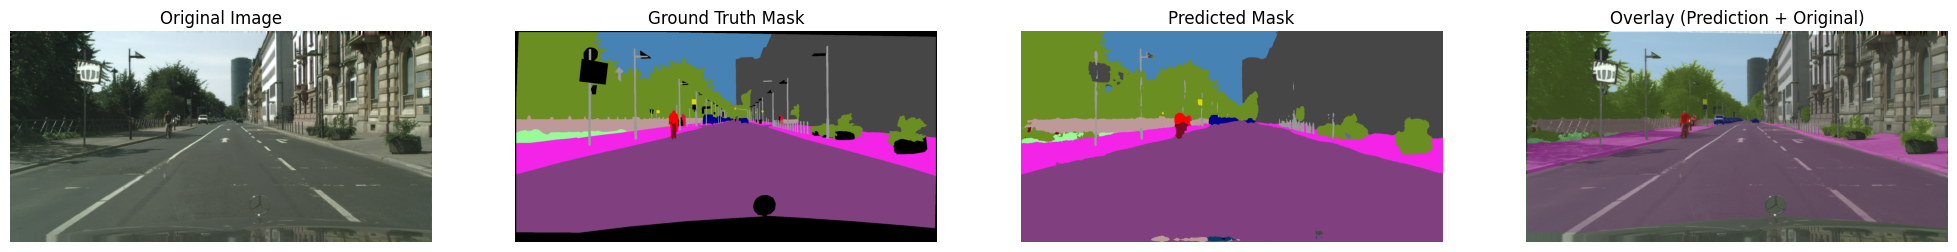

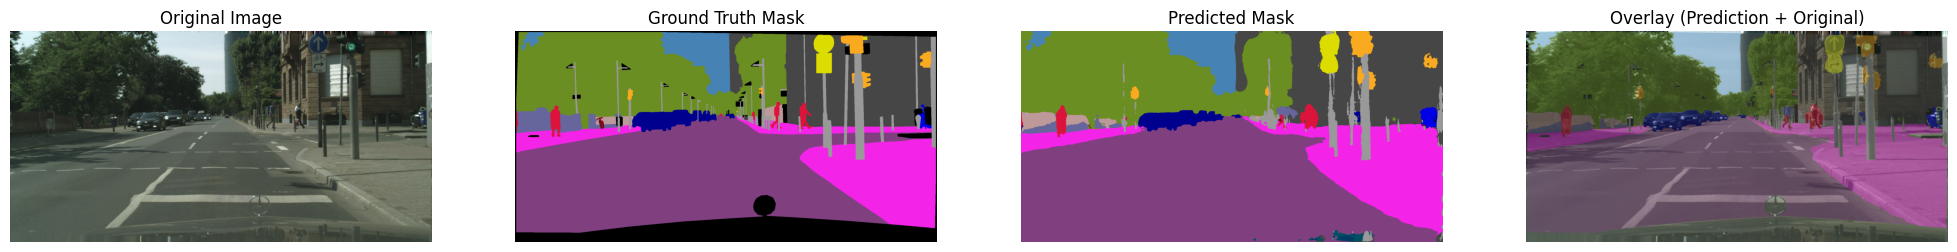

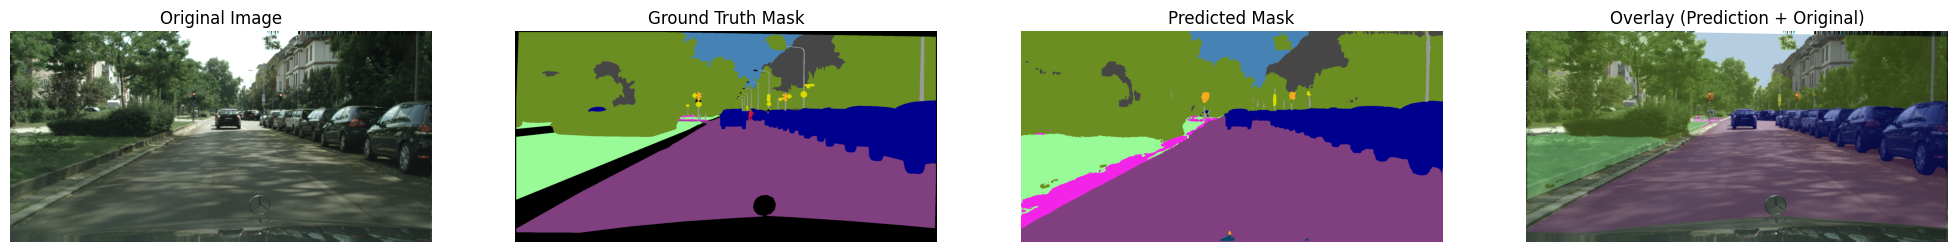

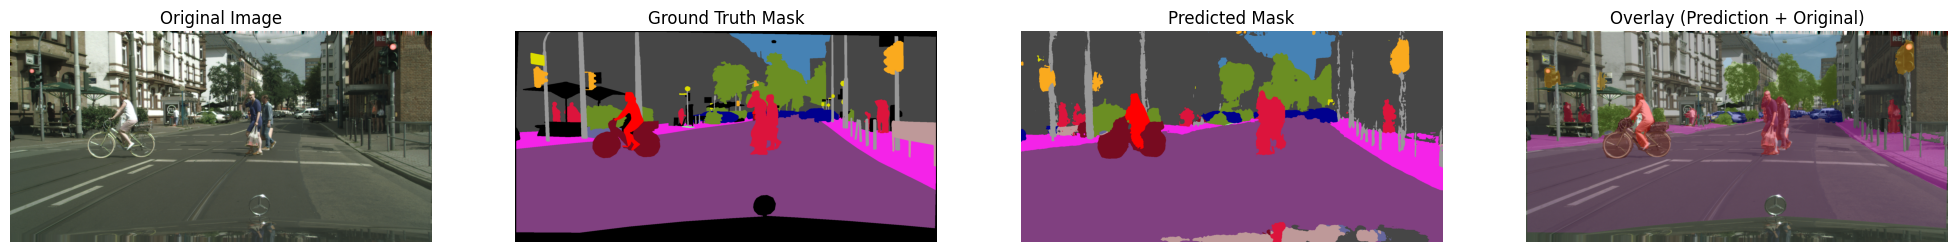

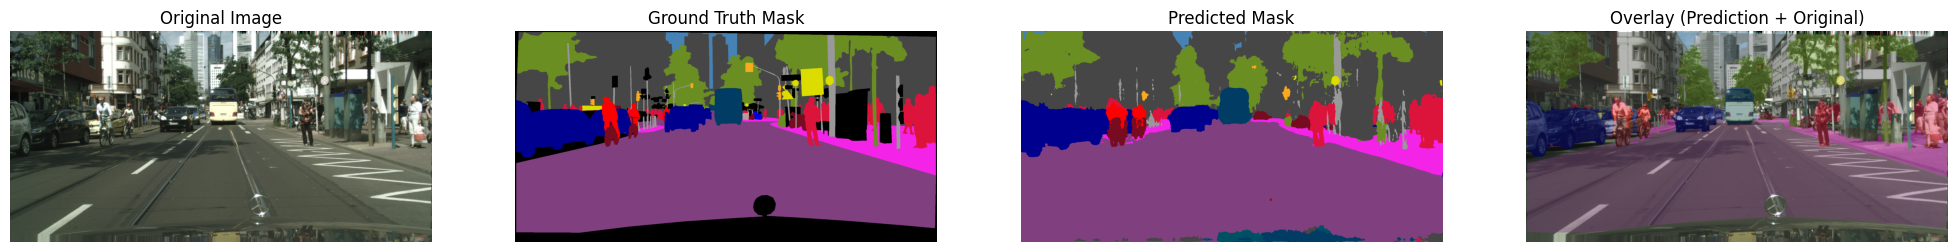

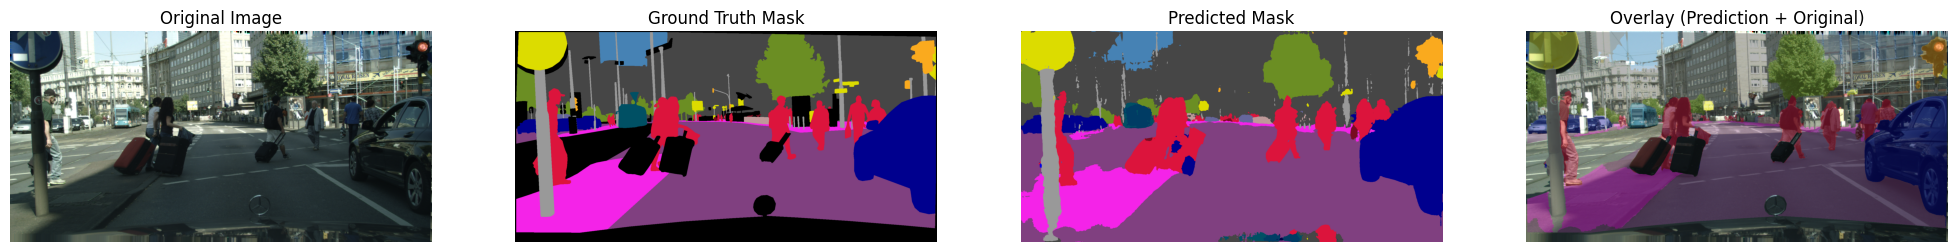

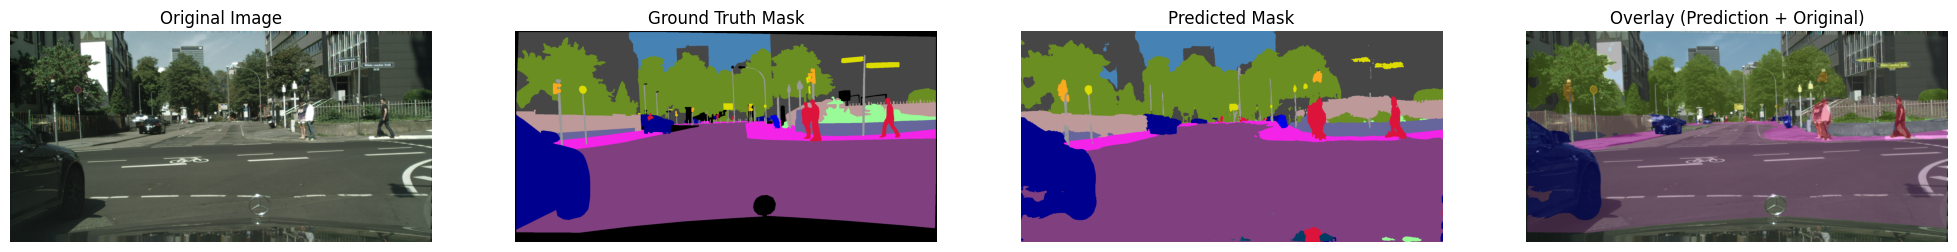

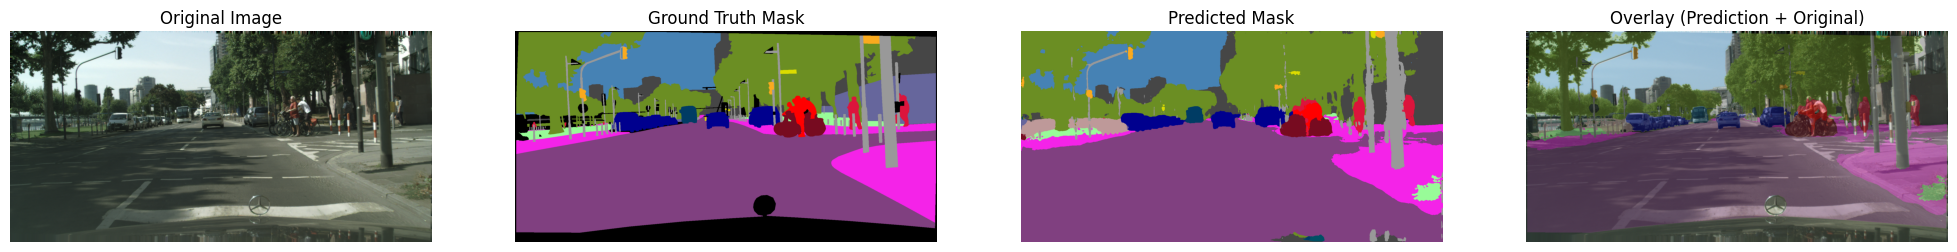

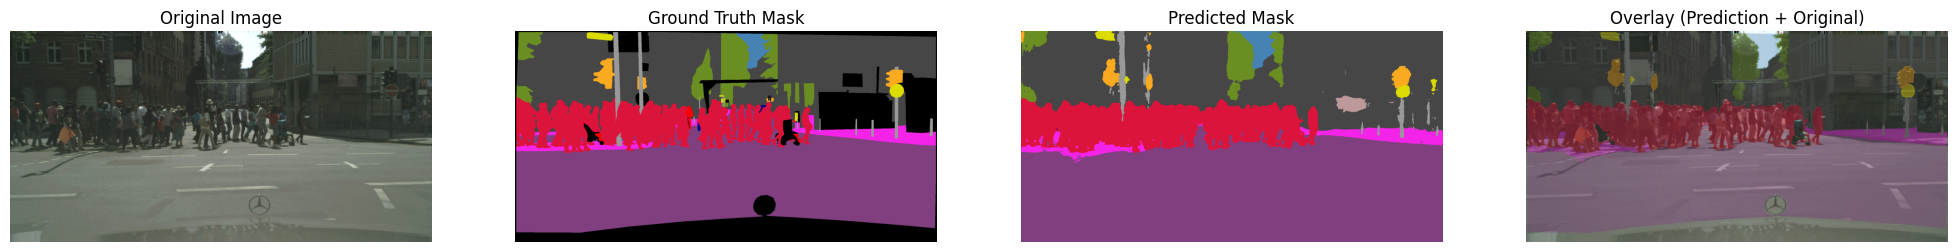

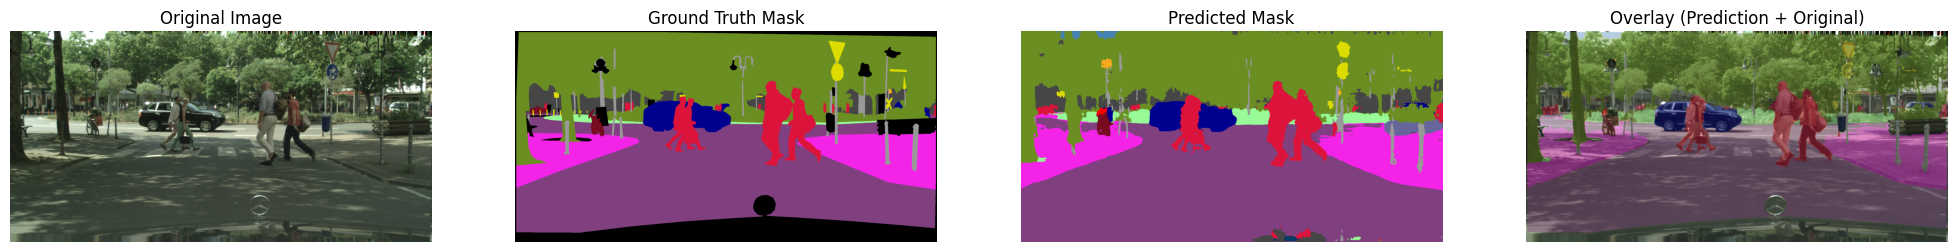

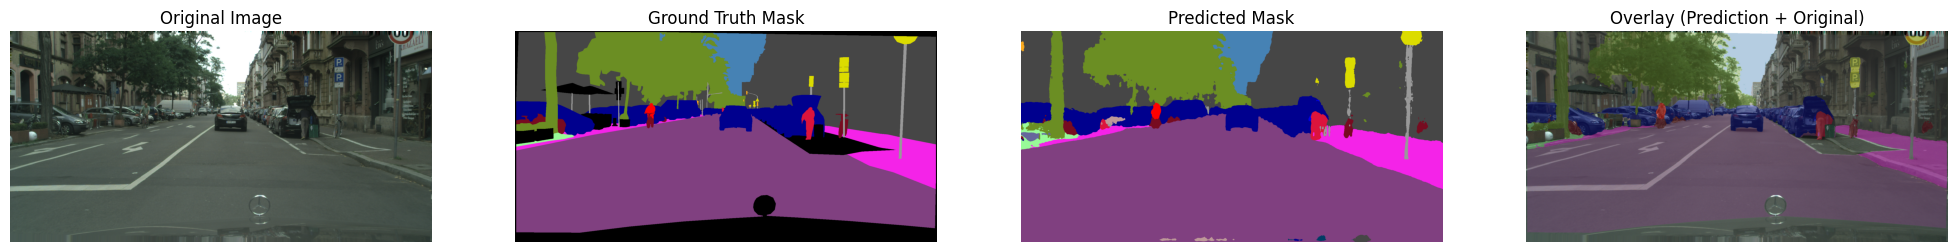

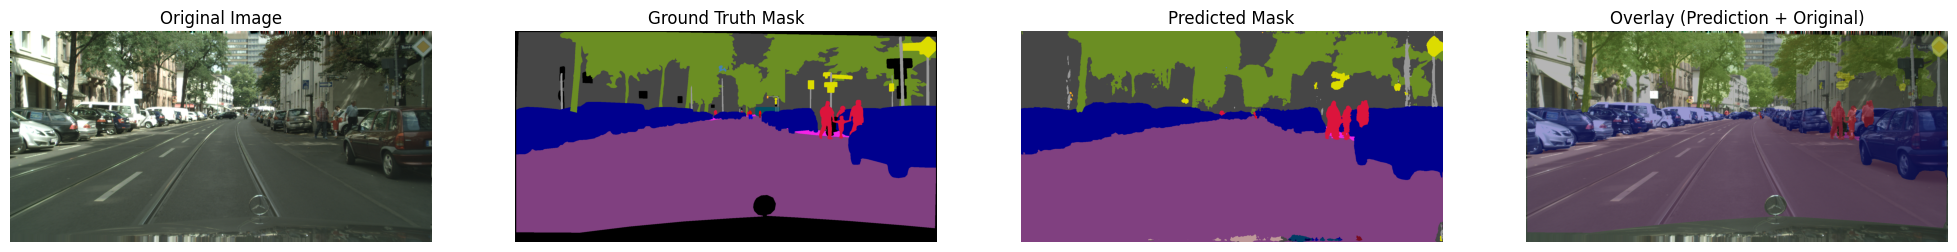

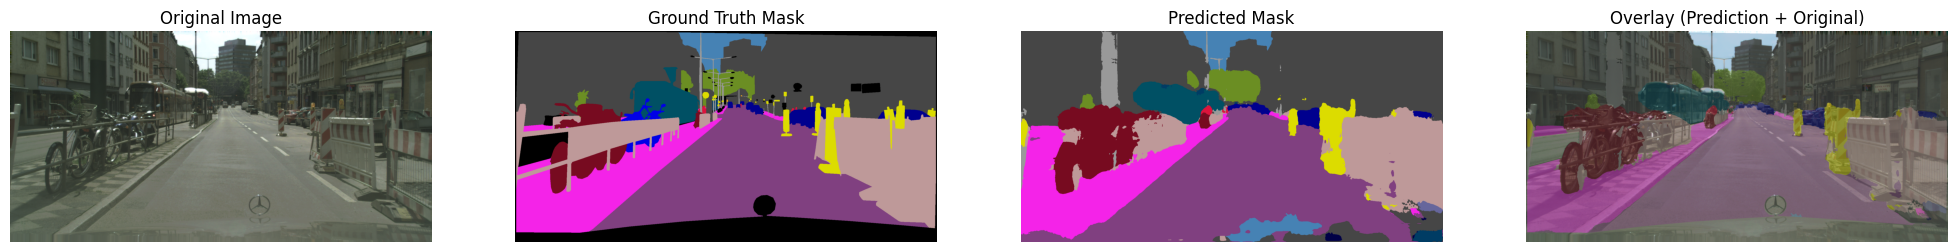

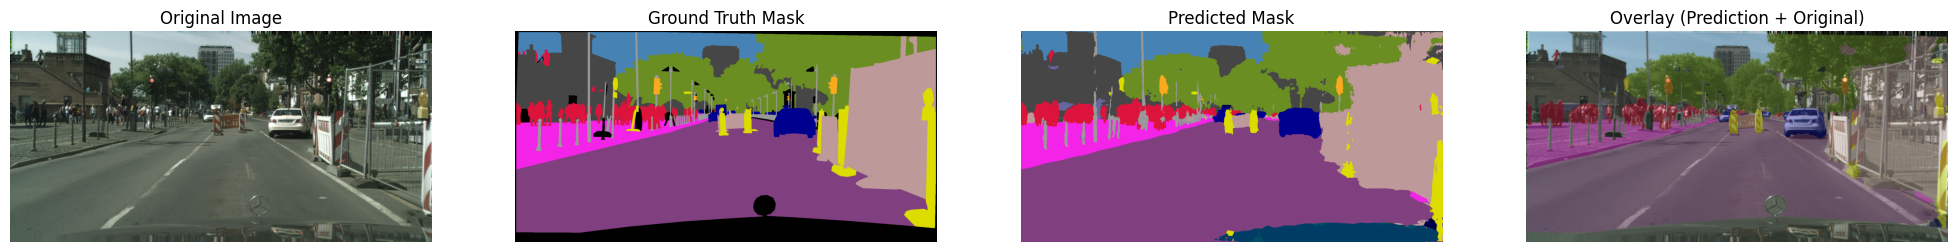

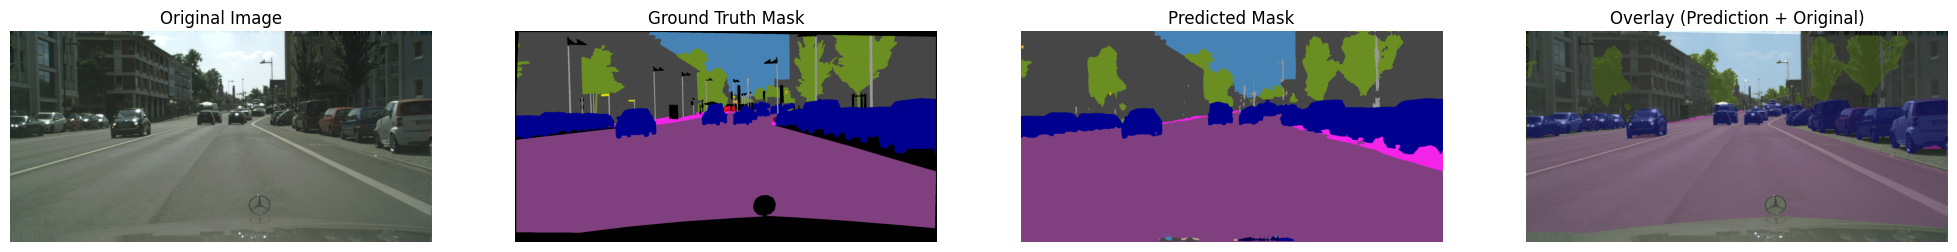

In [ ]:
# Replace `val_dataset` with your dataset instance
demo_inference(model, val_set, n_classes=19, num_samples=15)